In [1]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import CONSTANT as cons


### 1st Method: Merges all Parquet files

This method involves taking every patient's parquet file, and merges into one file

In [2]:
import parquet_merger as pm

In [3]:
# folder_path = "/Users/Patron/Documents/hms/hms_data/train_eegs"
# output_file = "/Users/Patron/Documents/hms/hms_data/train_eeg.parquet"
# pm.merge_parquet_files(folder_path, output_file)

Even though it will work, it will take alot of GPU power and take make the kernel fail due to it's massive time and space complexity

### 2nd Method: Taking a view at features of a singular patient

In [4]:
train = pd.read_csv(cons.PATH_TO_TRAIN_CSV)
print(train.shape)
display(train.head())

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
df1 = pd.read_parquet(cons.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet')
print(f'There are {len(cons.FEATURES)} raw eeg features')
print(list(cons.FEATURES))

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [6]:
import plot_time_eeg as PlotSeriesEEG

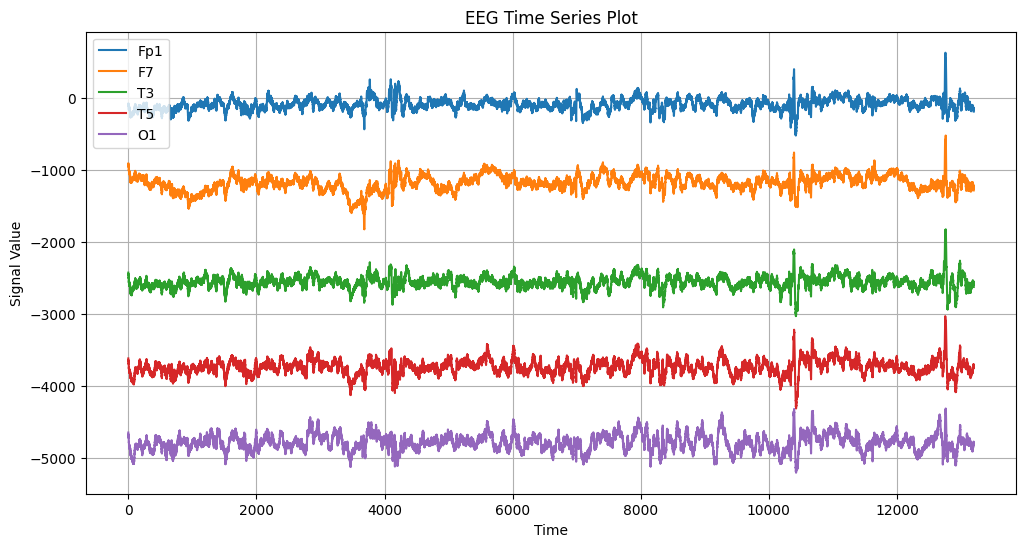

In [7]:
PlotSeriesEEG.plot_time_series(df1, cons.LL)

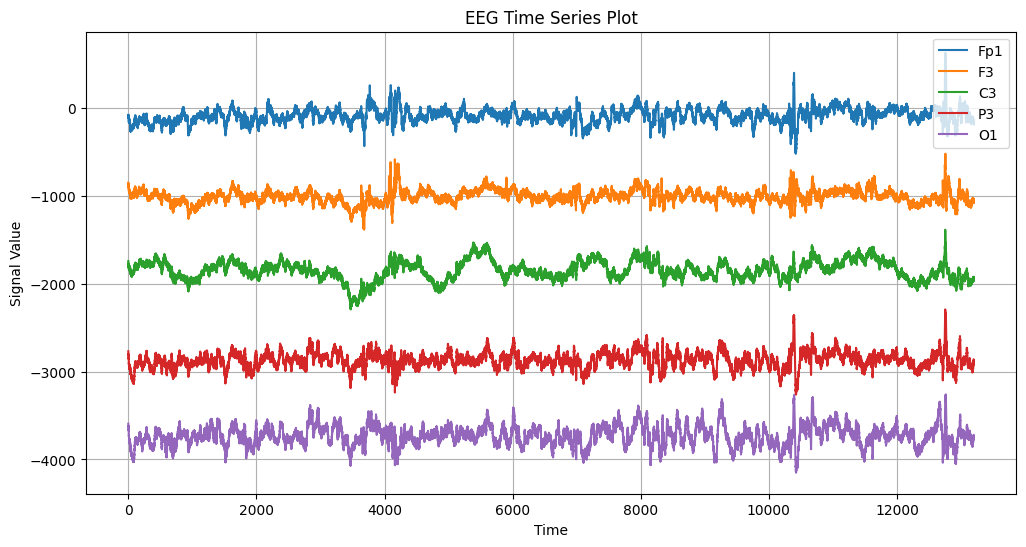

In [8]:
PlotSeriesEEG.plot_time_series(df1, cons.LP)

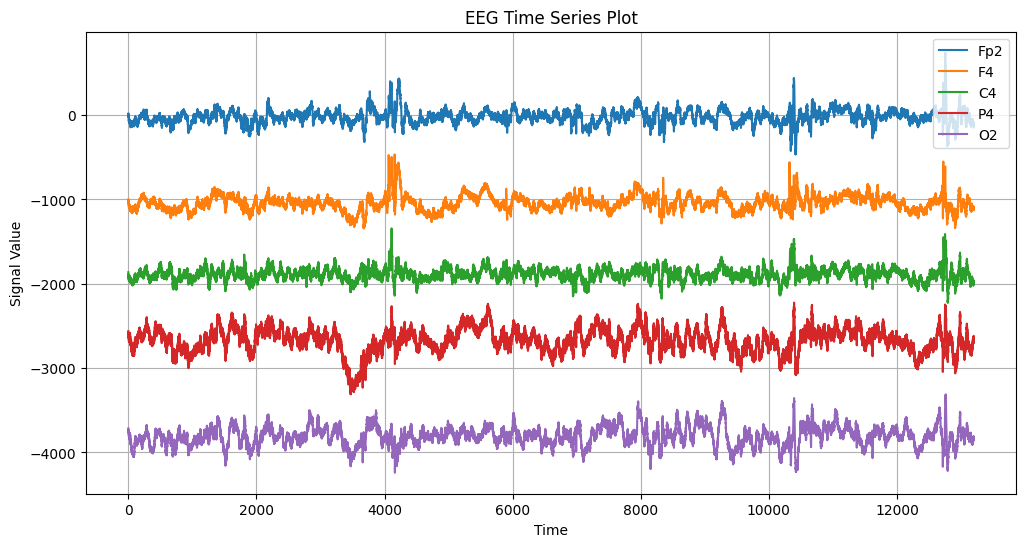

In [9]:
PlotSeriesEEG.plot_time_series(df1, cons.RP)

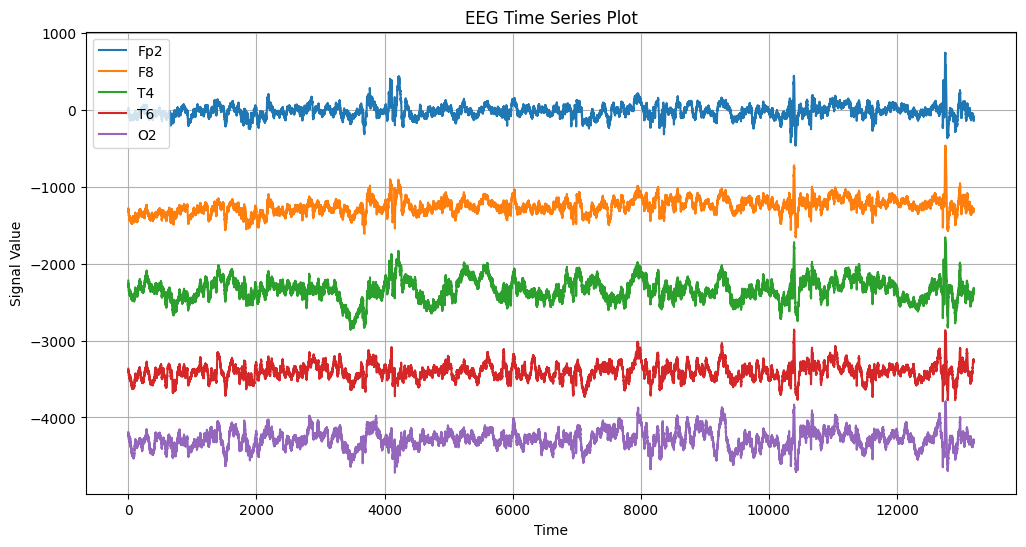

In [10]:
PlotSeriesEEG.plot_time_series(df1, cons.RR)

From research, we noticed that the 4 features: 'Fp1', 'O1', 'Fp2', 'O2' are the most important for any classification.

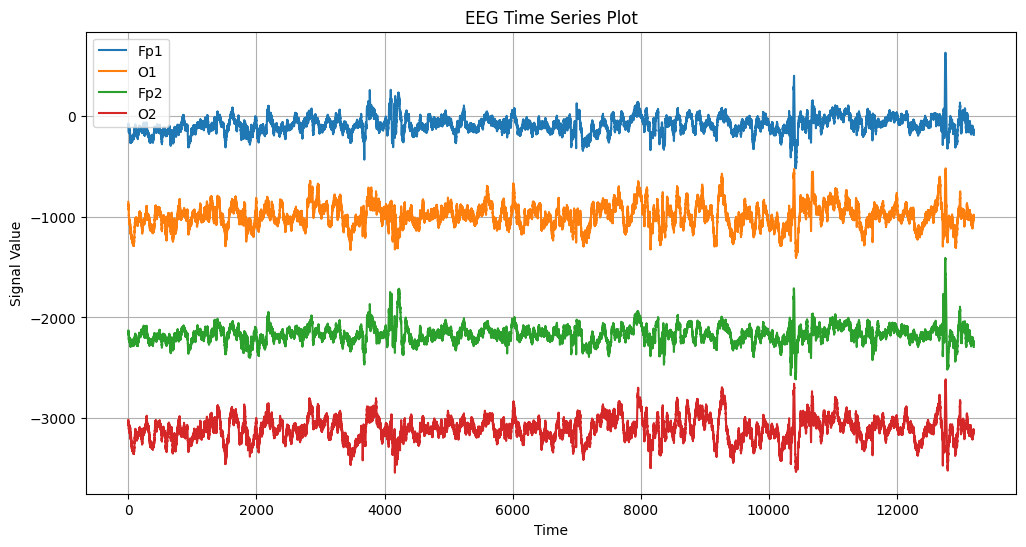

In [11]:
PlotSeriesEEG.plot_time_series(df1, cons.IMPT_ELECTRODES)

#### Filters + Conversions
##### 1. Fourier Transformation: Discrete Cosine Transform (DCT)

In [12]:
print(df1.head())
display(df1.index)


          Fp1         F3         C3         P3          F7         T3     T5  \
0  -75.360001  86.379997  65.470001  62.580002  170.350006  92.370003  39.68   
1 -107.739998  53.139999  32.590000  21.950001  140.500000  59.070000   4.26   
2 -103.050003  46.330002  10.750000   9.150000  137.820007  50.950001  -3.50   
3  -75.099998  77.870003  40.150002  31.790001  166.630005  76.769997  17.99   
4  -97.919998  58.209999  27.330000   5.340000  144.080002  47.200001 -10.43   

          O1         Fz         Cz         Pz    Fp2     F4         C4  \
0  89.870003  18.260000 -28.440001 -15.190000  16.93  13.81 -42.160000   
1  53.310001 -18.490000 -63.270000 -52.110001 -13.23 -16.42 -80.430000   
2  45.070000 -20.879999 -66.629997 -69.750000  -9.20 -21.40 -93.089996   
3  67.650002  11.140000 -32.950001 -38.509998  14.77   9.79 -66.480003   
4  40.250000 -12.350000 -52.500000 -54.919998 -10.07  -8.04 -90.820000   

          P4          F8          T4         T6         O2           EKG  

RangeIndex(start=0, stop=13200, step=1)

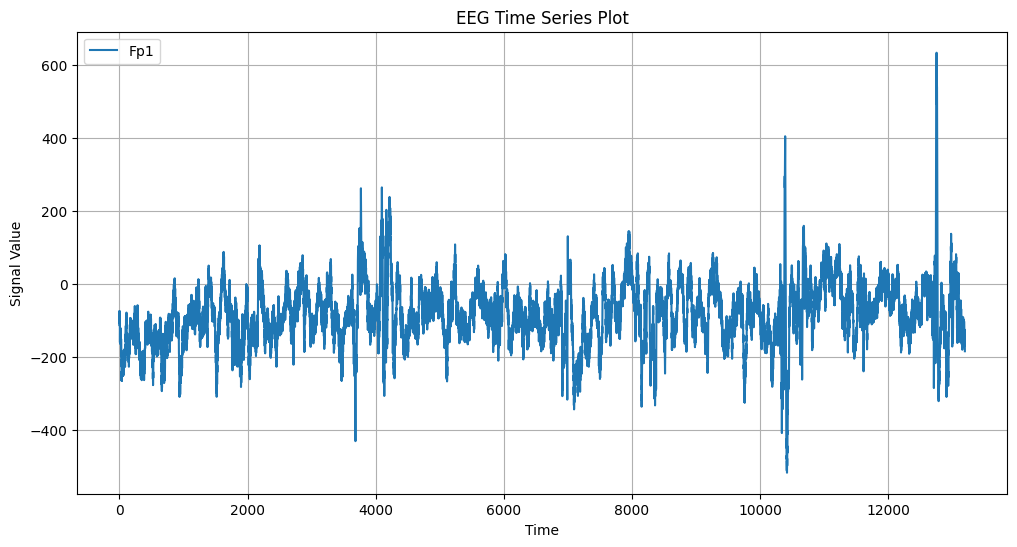

In [13]:
PlotSeriesEEG.plot_time_series(df1, ['Fp1'])

In [14]:
import transformations

In [15]:
SAMPLE_RATE = 1320 # Hertz
DURATION = 10  # Seconds

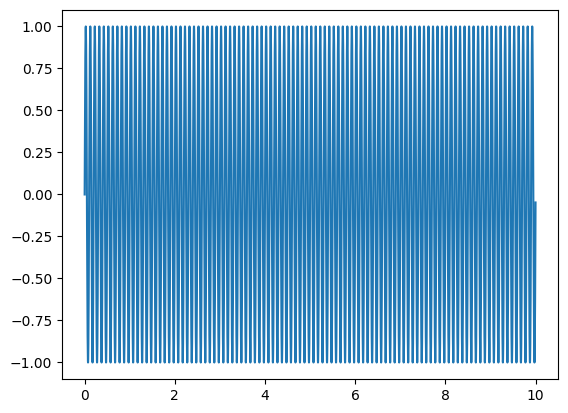

In [16]:
x, y = transformations.generate_sine_wave(10, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

In [17]:
# Adding Noise
# _, nice_tone = generate_sine_wave(400, cons.SAMPLE_RATE, cons.DURATION)
_, nice_tone = df1.index, df1['Fp1'].values.astype('float32')
_, noise_tone = transformations.generate_sine_wave(10, SAMPLE_RATE, DURATION)

mixed_tone = nice_tone + noise_tone

#### Normalization

/var/folders/b3/nkthvkld0lx0lmw9_r5z6ckh0000gq/T/ipykernel_18323/2772309244.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


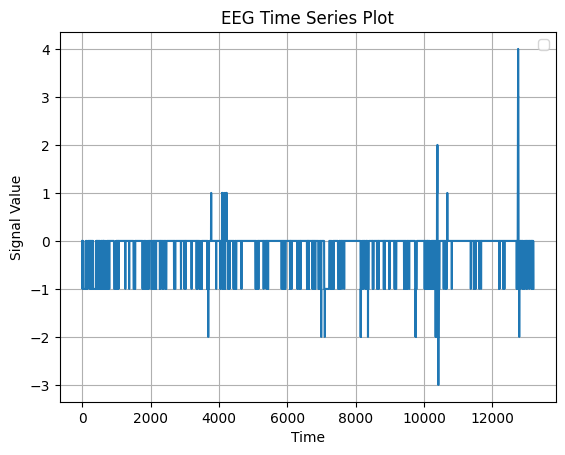

In [18]:
numpy_multiplier = 4
normalized_tone = transformations.normalization(mixed_tone,numpy_multiplier)

plt.plot(normalized_tone[:])
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('EEG Time Series Plot')
plt.legend()
plt.grid()
plt.show()


The range is going very large when converted. 
- Bad thing? (Outliers might be created). 
- Maybe good thing? (Easier to recognize now)

### Normalization matters alot. 

/var/folders/b3/nkthvkld0lx0lmw9_r5z6ckh0000gq/T/ipykernel_18323/4177494961.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


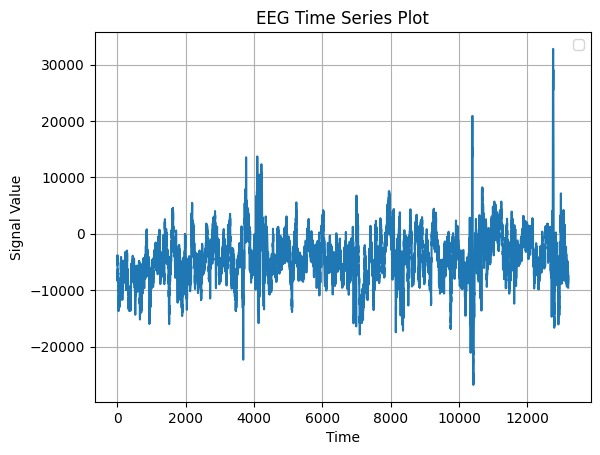

In [19]:
numpy_multiplier = 32767
normalized_tone = transformations.normalization(mixed_tone,numpy_multiplier)

plt.plot(normalized_tone[:])
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('EEG Time Series Plot')
plt.legend()
plt.grid()
plt.show()


2. Butter low pass filter

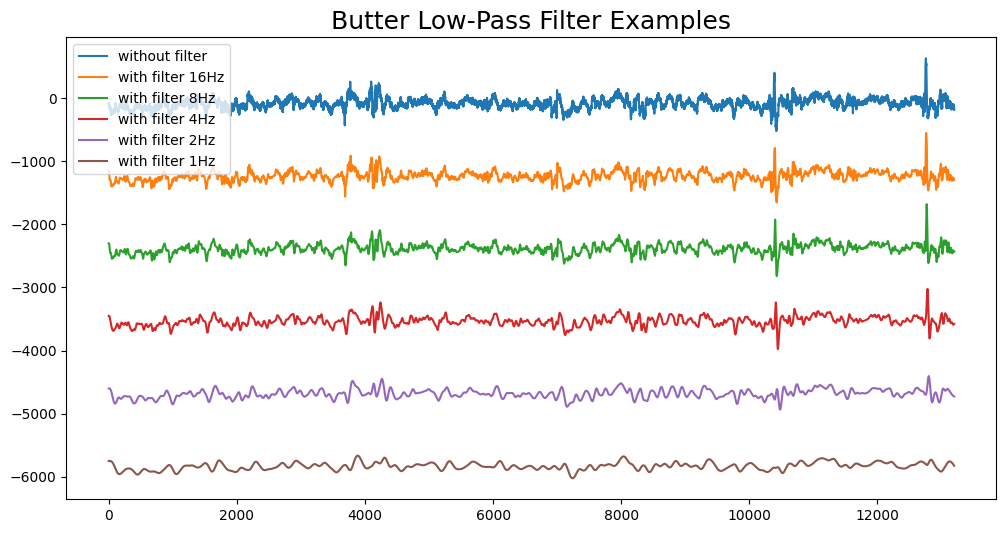

In [25]:
import filters

FREQS = [1, 2, 4, 8, 16][::-1]
x = df1.Fp1.values  # Convert Series to numpy array for proper indexing
filtered_signals = [x]  # Initialize list with original signal

# Apply filters
for k in FREQS:
    filtered_signals.append(filters.butter_lowpass_filter(x, cutoff_freq=k))

plt.figure(figsize=(12,6))
plt.plot(range(13_200), filtered_signals[0], label='without filter')

# Plot the filtered signals with vertical offsets for better visualization
for k in range(1, len(filtered_signals)):
    offset = k * (filtered_signals[0].max() - filtered_signals[0].min())
    plt.plot(range(13_200), filtered_signals[k] - offset, label=f'with filter {FREQS[k-1]}Hz')

plt.legend()
plt.title('Butter Low-Pass Filter Examples', size=18)
plt.show()


This reduces our range

### 3rd Method: Apply Different Transformations

Wavelet transform (WT)

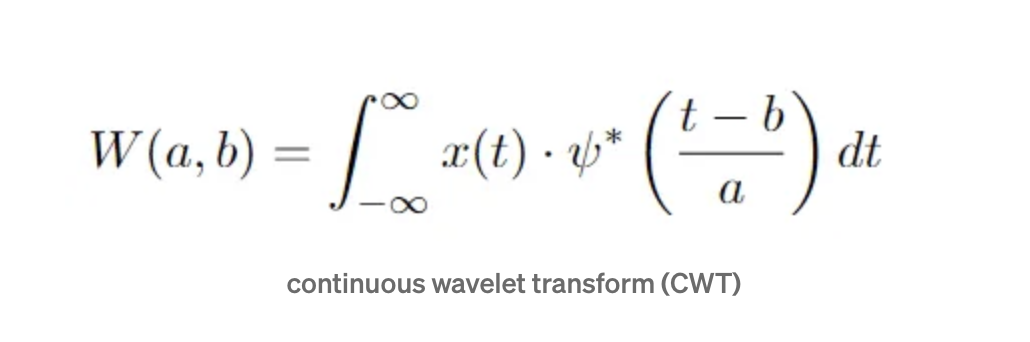

- ψ(t) is the mother wavelet, a function chosen based on the characteristics of the signal.
- a is the scaling factor (dilation), which controls the frequency.
- b is the translation factor, which controls the time shift.
- ψ is the complex conjugate of the wavelet function.

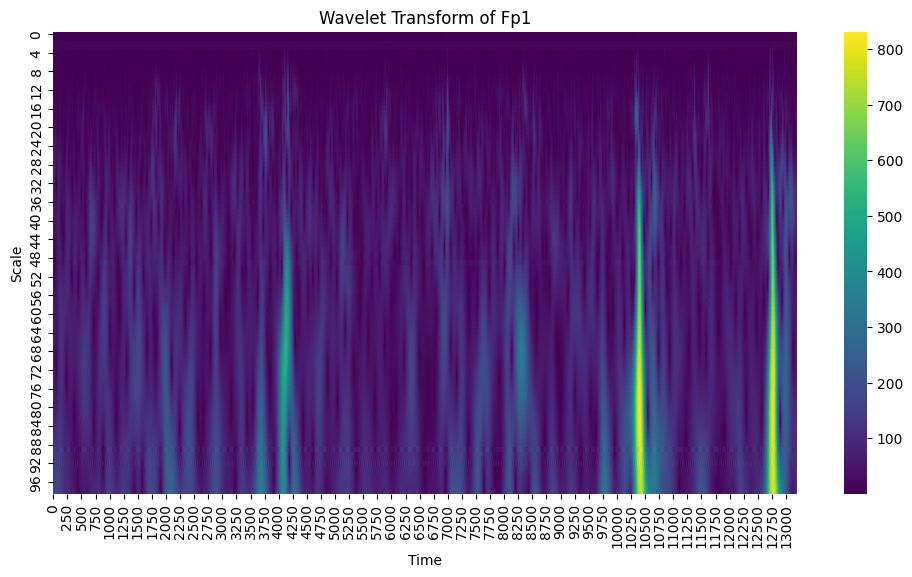

In [48]:
import seaborn as sns
signal = df1['Fp1'].values.astype('float32')
numpy_multi = 100
coefficients, frequencies = transformations.wavelet_transform(signal,numpy_multi)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(np.abs(coefficients), cmap='viridis')
ax.set_aspect('auto')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.title('Wavelet Transform of Fp1')
plt.show()

This transformation can help us in identifying the eeg spikes in a much better way

### WT + Butter low pass filter

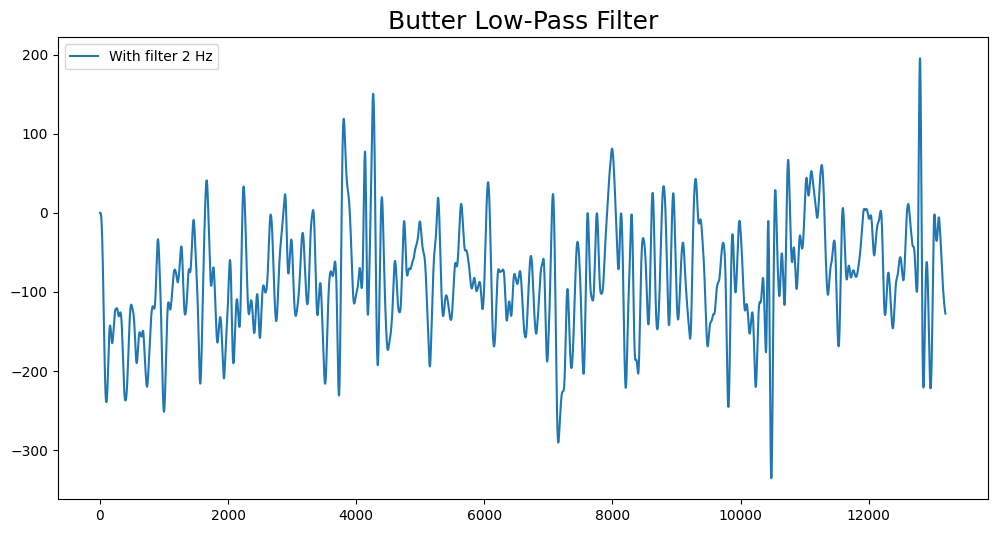

In [54]:
import filters

FREQS = 2
filtered_signals = filters.butter_lowpass_filter(df1.Fp1.values, cutoff_freq=FREQS)
plt.figure(figsize=(12,6))
plt.plot(range(13_200), filtered_signals, label=f'With filter {FREQS} Hz')

plt.legend()
plt.title('Butter Low-Pass Filter', size=18)
plt.show()


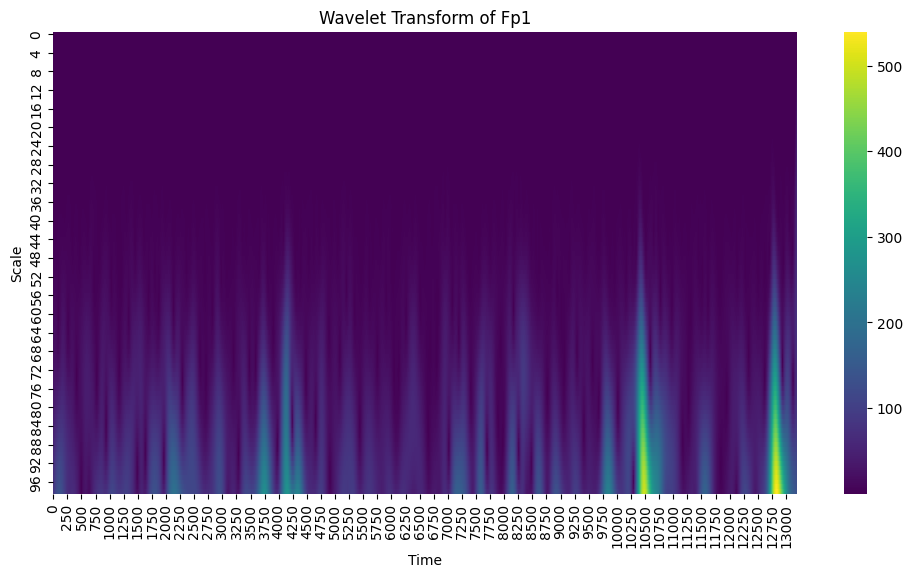

In [55]:
numpy_multi = 100
coefficients, frequencies = transformations.wavelet_transform(filtered_signals, numpy_multi)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(np.abs(coefficients), cmap='viridis')
ax.set_aspect('auto')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.title('Wavelet Transform of Fp1')
plt.show()